In [16]:
# Configuration de l’environnement
# Cette section valide : 
# "J’ai importé les librairies nécessaires et configuré l’environnement pour l’analyse."

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set()

pd.set_option("display.max_columns", None)

In [17]:
# Analyse exploratoire des fichiers
# "J’ai chargé et observé séparément chaque fichier de données."

sirh = pd.read_csv("../data/sirh.csv")
perf = pd.read_csv("../data/performance.csv")
survey = pd.read_csv("../data/survey.csv")

sirh.shape, perf.shape, survey.shape



((10, 7), (10, 4), (10, 5))

In [18]:
# Nettoyage des données
# "J’ai harmonisé les noms de colonnes et nettoyé les variables textuelles."

def clean_columns(df):
    df.columns = (
        df.columns
        .str.lower()
        .str.strip()
        .str.replace(" ", "_")
    )
    return df

sirh = clean_columns(sirh)
perf = clean_columns(perf)
survey = clean_columns(survey)

# pour nettoyer les variables catégorielles
sirh["department"] = sirh["department"].apply(lambda x: x.lower().strip())
sirh["gender"] = sirh["gender"].apply(lambda x: x.lower().strip())


In [19]:
# Création du DataFrame central
# "J’ai fusionné les fichiers pour obtenir un dataset exploitable."

df = (
    sirh
    .merge(perf, on="employee_id", how="inner")
    .merge(survey, on="employee_id", how="inner")
)

df.head()


,employee_id,age,salary,tenure_years,department,gender,job_level,performance_score,manager_rating,satisfaction_global,work_life_balance,engagement_score,stress_level,has_left
0,1,28,38000,1.2,it,f,Junior,3.2,3.0,2.5,2.8,3.0,4.2,1
1,2,34,45000,3.5,finance,m,Intermediate,4.1,4.0,3.8,3.5,4.0,2.1,0
2,3,42,52000,6.8,hr,f,Senior,4.8,5.0,4.5,4.2,4.8,1.9,0
3,4,31,40000,2.0,it,m,Junior,3.0,2.8,2.9,2.7,3.0,3.9,1
4,5,26,36000,0.8,marketing,f,Junior,2.5,2.0,2.3,2.1,2.5,4.5,1


In [20]:
# Gestion des valeurs manquantes
# "J’ai identifié et traité les valeurs manquantes."

df.isna().mean().sort_values(ascending=False)

# Imputation simple justifiée
df["manager_rating"] = df["manager_rating"].fillna(df["manager_rating"].median())
df["performance_score"] = df["performance_score"].fillna(df["performance_score"].median())


In [21]:
# Analyse descriptive
# "J’ai calculé les statistiques descriptives pour comprendre les variables."

df.describe(include="all").T



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
employee_id,10.0,NaN,NaN,NaN,5.5,3.02765,1.0,3.25,5.5,7.75,10.0
age,10.0,NaN,NaN,NaN,34.7,6.498718,26.0,29.5,33.5,40.25,45.0
salary,10.0,NaN,NaN,NaN,45500.0,8031.189202,36000.0,39250.0,43500.0,51000.0,60000.0
tenure_years,10.0,NaN,NaN,NaN,3.99,3.116069,0.8,1.4,3.2,6.15,10.0
department,10,4,it,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,10,2,f,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_level,10,3,Junior,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
performance_score,10.0,NaN,NaN,NaN,3.83,0.840701,2.5,3.125,3.95,4.525,4.9
manager_rating,10.0,NaN,NaN,NaN,3.74,1.010171,2.0,3.05,3.75,4.575,5.0
satisfaction_global,10.0,NaN,NaN,NaN,3.51,0.847808,2.3,2.925,3.5,4.2,4.7


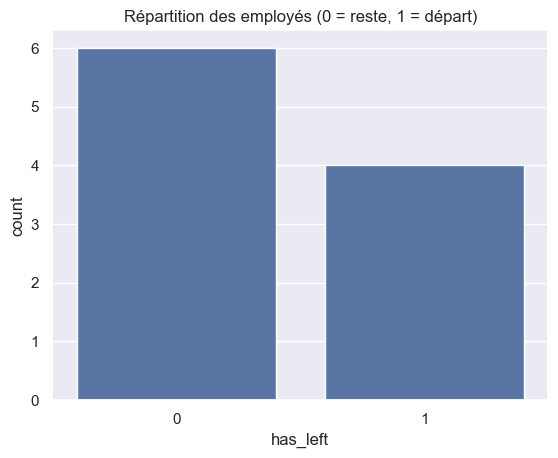

has_left
0    0.6
1    0.4
Name: proportion, dtype: float64

In [22]:
# Répartition des classes
# "J’ai analysé la distribution de la variable cible."

sns.countplot(data=df, x="has_left")
plt.title("Répartition des employés (0 = reste, 1 = départ)")
plt.show()

df["has_left"].value_counts(normalize=True)


In [23]:
# Feature engineering
# "J’ai créé de nouvelles variables à partir des données existantes."

df["salary_per_year_of_tenure"] = df["salary"] / (df["tenure_years"] + 0.1)
df["stress_vs_satisfaction"] = df["stress_level"] - df["satisfaction_global"]

df[["salary_per_year_of_tenure", "stress_vs_satisfaction"]].head()


,salary_per_year_of_tenure,stress_vs_satisfaction
0,29230.769231,1.7
1,12500.000000,-1.7
2,7536.231884,-2.6
3,19047.619048,1.0
4,40000.000000,2.2


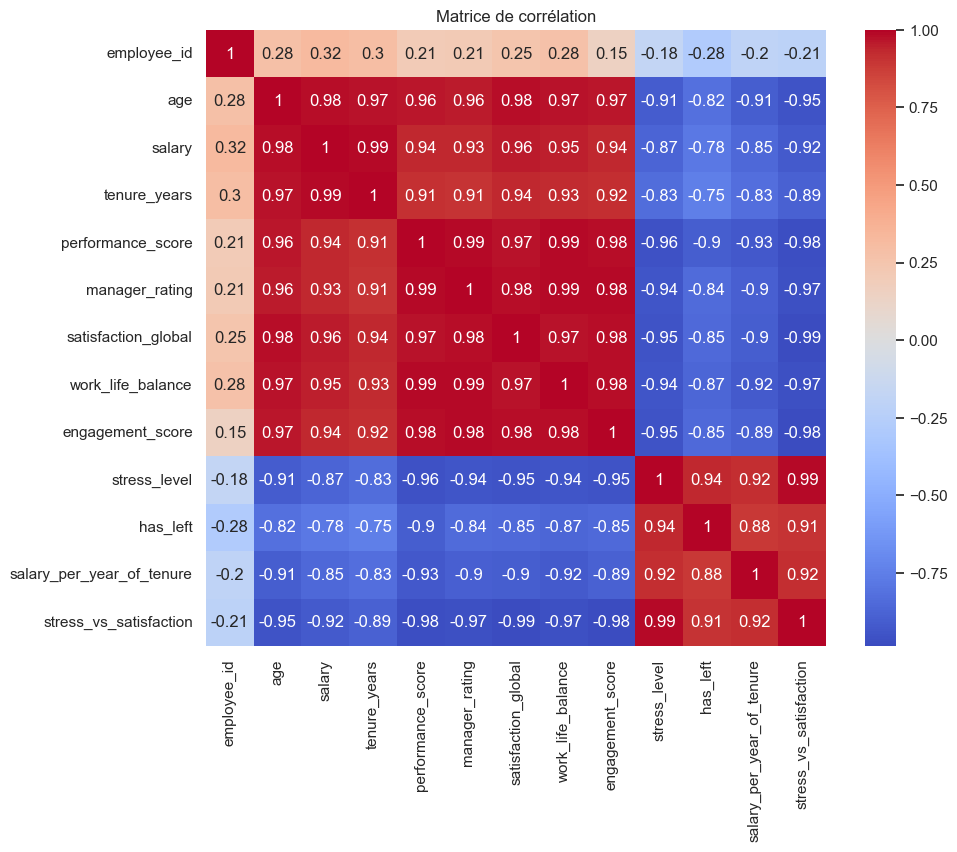

In [24]:
# Analyse de corrélation
# "J’ai analysé les corrélations pour identifier des features redondantes."

plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes("number").corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()


In [25]:
import numpy as np

corr_matrix = df.select_dtypes(include="number").corr()



In [26]:
threshold = 0.8  # seuil de corrélation forte

high_corr = (
    corr_matrix.abs()
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

high_corr.columns = ["feature_1", "feature_2", "correlation"]
high_corr[high_corr["correlation"] > threshold]


,feature_1,feature_2,correlation
12,age,salary,0.982475
13,age,tenure_years,0.971556
14,age,performance_score,0.963774
15,age,manager_rating,0.958308
16,age,satisfaction_global,0.978685
...,...,...,...
73,stress_level,salary_per_year_of_tenure,0.917068
74,stress_level,stress_vs_satisfaction,0.991028
75,has_left,salary_per_year_of_tenure,0.884396
76,has_left,stress_vs_satisfaction,0.906818


In [ ]:
# suppression des features redondantes (si nécessaire)


features_to_drop = ["manager_rating"]

df = df.drop(columns=features_to_drop, errors="ignore")


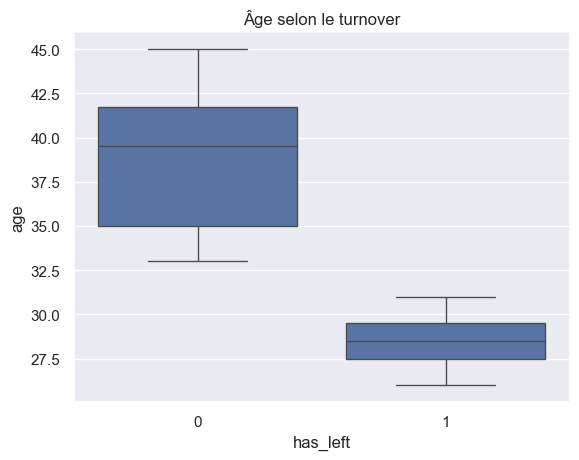

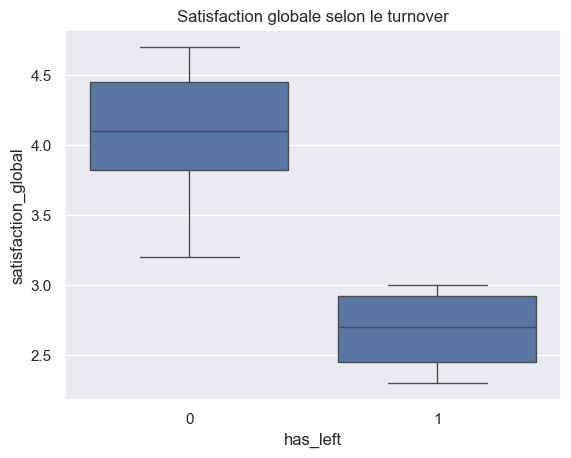

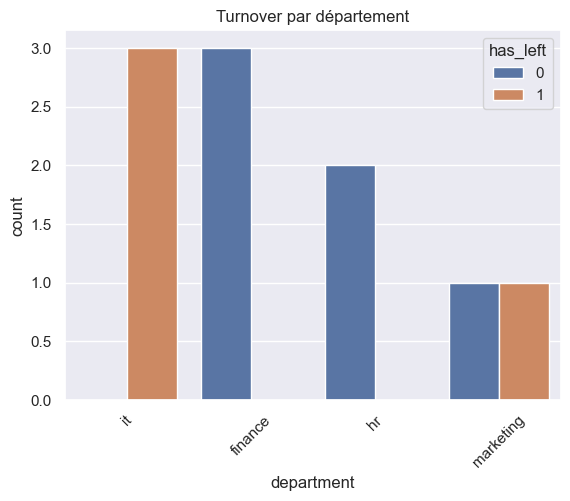

In [28]:
# Analyse des facteurs liés au turnover
# "J’ai comparé les variables explicatives en fonction de la cible."

sns.boxplot(data=df, x="has_left", y="age")
plt.title("Âge selon le turnover")
plt.show()

sns.boxplot(data=df, x="has_left", y="satisfaction_global")
plt.title("Satisfaction globale selon le turnover")
plt.show()

sns.countplot(data=df, x="department", hue="has_left")
plt.title("Turnover par département")
plt.xticks(rotation=45)
plt.show()


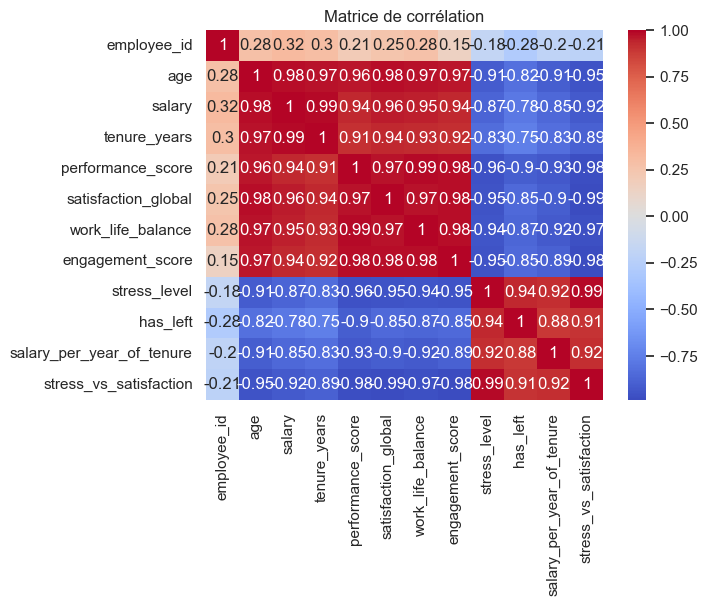

In [29]:
#Matrice de corrélation 

corr_matrix = df.select_dtypes(include="number").corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()


In [30]:
# détection de features quantitatives redondantes

threshold = 0.8 

high_corr = (
    corr_matrix.abs()
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

high_corr.columns = ["feature_1", "feature_2", "correlation"]
high_corr[high_corr["correlation"] > threshold]


,feature_1,feature_2,correlation
11,age,salary,0.982475
12,age,tenure_years,0.971556
13,age,performance_score,0.963774
14,age,satisfaction_global,0.978685
15,age,work_life_balance,0.971403
16,age,engagement_score,0.965682
17,age,stress_level,0.912658
18,age,has_left,0.821102
19,age,salary_per_year_of_tenure,0.906236
20,age,stress_vs_satisfaction,0.952715
